# Fine-tuning Whisper Small for Audio Classification

## Introduction

This notebook demonstrates how to fine-tune OpenAI's Whisper Small model for audio classification tasks. Whisper is a powerful speech recognition model that can be adapted for various audio-related tasks beyond just transcription.

In this tutorial, we'll cover:
1. Setting up the environment and installing required packages
2. Loading and preprocessing audio data
3. Preparing the Whisper model for fine-tuning
4. Training the model on our classification task
5. Evaluating the model's performance
6. Making predictions with the fine-tuned model

This notebook is designed for educational purposes and assumes basic familiarity with Python, PyTorch, and machine learning concepts.

## 1. Environment Setup

First, let's install all the necessary packages. We'll need:
- `transformers`: For accessing the Whisper model
- `datasets`: For handling our audio dataset
- `librosa`: For audio processing
- `torch` and `torchaudio`: For deep learning operations
- `evaluate`: For model evaluation
- `accelerate`: For faster training
- `soundfile`: For audio file handling
- `matplotlib` and `seaborn`: For visualizations

In [1]:
# Install required packages
! pip install transformers datasets librosa torch torchaudio evaluate accelerate soundfile matplotlib seaborn standard-aifc standard-sunau

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
# Import necessary libraries
import os
import torch
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Audio, Dataset, DatasetDict
from transformers import WhisperProcessor, WhisperForAudioClassification, WhisperFeatureExtractor
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from IPython.display import Audio as IPythonAudio

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Loading and Exploring the Dataset

For this tutorial, we'll use the ESC-50 dataset (Environmental Sound Classification), which contains 2,000 labeled environmental audio recordings across 50 classes. Each recording is 5 seconds long.

Let's load the dataset and explore its structure.

In [3]:
# Load the ESC-50 dataset
dataset = load_dataset("ashraq/esc50")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/345 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

(…)-00000-of-00002-2f1ab7b824ec751f.parquet:   0%|          | 0.00/387M [00:00<?, ?B/s]

(…)-00001-of-00002-27425e5c1846b494.parquet:   0%|          | 0.00/387M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take', 'audio'],
        num_rows: 2000
    })
})


In [4]:
# Explore the dataset structure
print(f"Available splits: {dataset.keys()}")
print(f"Number of examples in train: {len(dataset['train'])}")
print(f"\nFeatures: {dataset['train'].features}")

Available splits: dict_keys(['train'])
Number of examples in train: 2000

Features: {'filename': Value(dtype='string', id=None), 'fold': Value(dtype='int64', id=None), 'target': Value(dtype='int64', id=None), 'category': Value(dtype='string', id=None), 'esc10': Value(dtype='bool', id=None), 'src_file': Value(dtype='int64', id=None), 'take': Value(dtype='string', id=None), 'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None)}


In [5]:
# Let's look at a few examples
print("Sample from the dataset:")
sample = dataset['train'][0]
print(f"Audio file: {sample['audio']['path']}")
print(f"Label: {sample['target']} (Class name: {sample['category']})")

# Display the audio
IPythonAudio(data=sample['audio']['array'], rate=sample['audio']['sampling_rate'])

Sample from the dataset:
Audio file: None
Label: 0 (Class name: dog)


In [6]:
# Get all unique class labels
labels = dataset['train'].unique('category')
num_labels = len(labels)
print(f"Number of classes: {num_labels}")
print(f"Class labels: {labels}")

# Create a label2id and id2label mapping
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

Number of classes: 50
Class labels: ['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train', 'sheep', 'water_drops', 'church_bells', 'clock_alarm', 'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow', 'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter', 'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine', 'breathing', 'crying_baby', 'hand_saw', 'coughing', 'glass_breaking', 'snoring', 'toilet_flush', 'pig', 'washing_machine', 'clock_tick', 'sneezing', 'rooster', 'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets']


## 3. Data Preprocessing

Now, we need to preprocess our audio data to make it suitable for the Whisper model. This involves:
1. Loading the Whisper processor
2. Creating a preprocessing function
3. Applying the preprocessing to our dataset

In [8]:
# Load the Whisper feature extractor and processor
model_name = "openai/whisper-small"
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name)
processor = WhisperProcessor.from_pretrained(model_name)

In [9]:
def downsample_audio(audio_array, orig_sr=44100, target_sr=16000):
    """
    Downsample audio from original sampling rate to target sampling rate.
    """
    return librosa.resample(y=audio_array, orig_sr=orig_sr, target_sr=target_sr)

In [10]:
# Define preprocessing function
def preprocess_function(examples):
    # Process audio
    audio_arrays = []
    for audio in examples["audio"]:
        audio_array = audio["array"]
        sampling_rate = audio["sampling_rate"]
        audio_array = downsample_audio(audio_array, sampling_rate, 16000)
        audio_arrays.append(audio_array)

    # Extract features
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=16000,
        return_tensors="pt",
        padding="max_length",
        max_length=480000
    )

    # Get labels
    labels = [label2id[category] for category in examples["category"]]

    return {
        "input_features": inputs.input_features,
        "labels": labels
    }

In [11]:
# Apply preprocessing to the dataset
# We'll use a smaller subset for demonstration purposes
train_dataset = dataset["train"].select(range(0, 1000, 1))
test_dataset = dataset["train"].select(range(1000, 1500, 1))

# Process in batches to avoid memory issues
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=8,
    remove_columns=train_dataset.column_names
)

test_dataset = test_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=8,
    remove_columns=test_dataset.column_names
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## 4. Model Preparation

Now, we'll prepare the Whisper model for our audio classification task. We need to:
1. Load the pre-trained Whisper Small model
2. Modify it for classification
3. Set up the training arguments and evaluation metrics

In [12]:
# Load the Whisper model for audio classification
model = WhisperForAudioClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Move model to the appropriate device
model = model.to(device)

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-small and are newly initialized: ['model.classifier.bias', 'model.classifier.weight', 'model.projector.bias', 'model.projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [14]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    fp16=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"  # Disable wandb or other reporting
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

## 5. Untrained Model Evaluation and Visualization

Let's set up the evaluation code and evaluate the untrained model on the test set.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


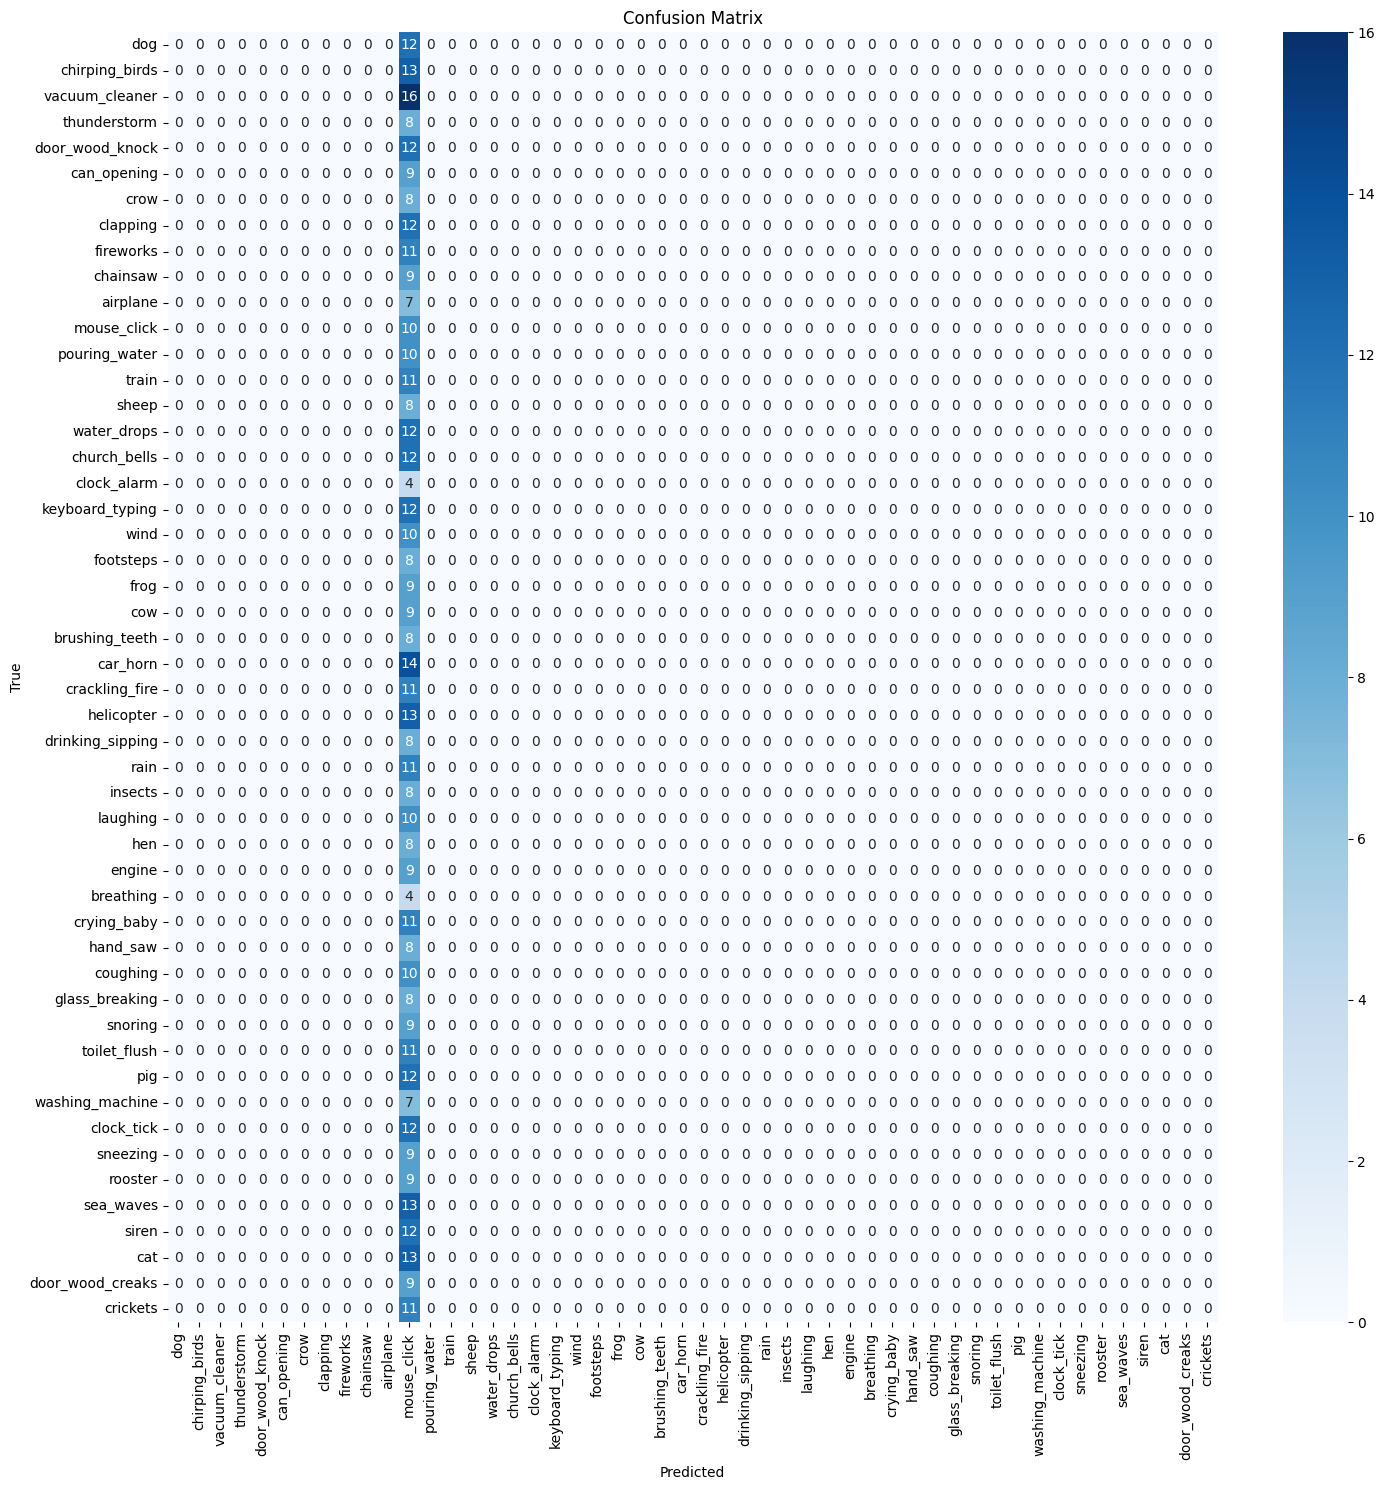

In [16]:
# Get predictions on the test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Create a confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(15, 15))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(labels, preds)

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Class': [id2label[i] for i in range(num_labels)],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Support': support
})

# Sort by F1 score
metrics_df = metrics_df.sort_values('F1 Score', ascending=False)
metrics_df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Class,Precision,Recall,F1 Score,Support
11,mouse_click,0.02,1.0,0.039216,10
0,dog,0.00,0.0,0.000000,12
1,chirping_birds,0.00,0.0,0.000000,13
2,vacuum_cleaner,0.00,0.0,0.000000,16
4,door_wood_knock,0.00,0.0,0.000000,12
3,thunderstorm,0.00,0.0,0.000000,8
6,crow,0.00,0.0,0.000000,8
7,clapping,0.00,0.0,0.000000,12
8,fireworks,0.00,0.0,0.000000,11
5,can_opening,0.00,0.0,0.000000,9


## 6. Training the Model

Now we're ready to fine-tune the Whisper model on our audio classification task. This process will take some time, especially if you're training on a CPU.

In [18]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,No log,2.269870,0.002600,0.430000,0.431530,0.430000,0.369901
2,No log,1.440127,0.002600,0.636000,0.700289,0.636000,0.611809
3,No log,1.025384,0.002600,0.752000,0.768300,0.752000,0.737099


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 

TrainOutput(global_step=375, training_loss=1.8731053059895832, metrics={'train_runtime': 1068.3432, 'train_samples_per_second': 2.808, 'train_steps_per_second': 0.351, 'total_flos': 3.7675508832e+17, 'train_loss': 1.8731053059895832, 'epoch': 3.0})

In [19]:
# Evaluate the model on the test set
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

Evaluation Results: {'eval_loss': 1.0253835916519165, 'eval_model_preparation_time': 0.0026, 'eval_accuracy': 0.752, 'eval_precision': 0.7682999087513793, 'eval_recall': 0.752, 'eval_f1': 0.7370994521180807, 'eval_runtime': 90.7926, 'eval_samples_per_second': 5.507, 'eval_steps_per_second': 0.694, 'epoch': 3.0}


## 7. Fine-tuned Model Evaluation and Visualization

Let's set up model evaluation code and evaluate the fine-tuned model on the test set.

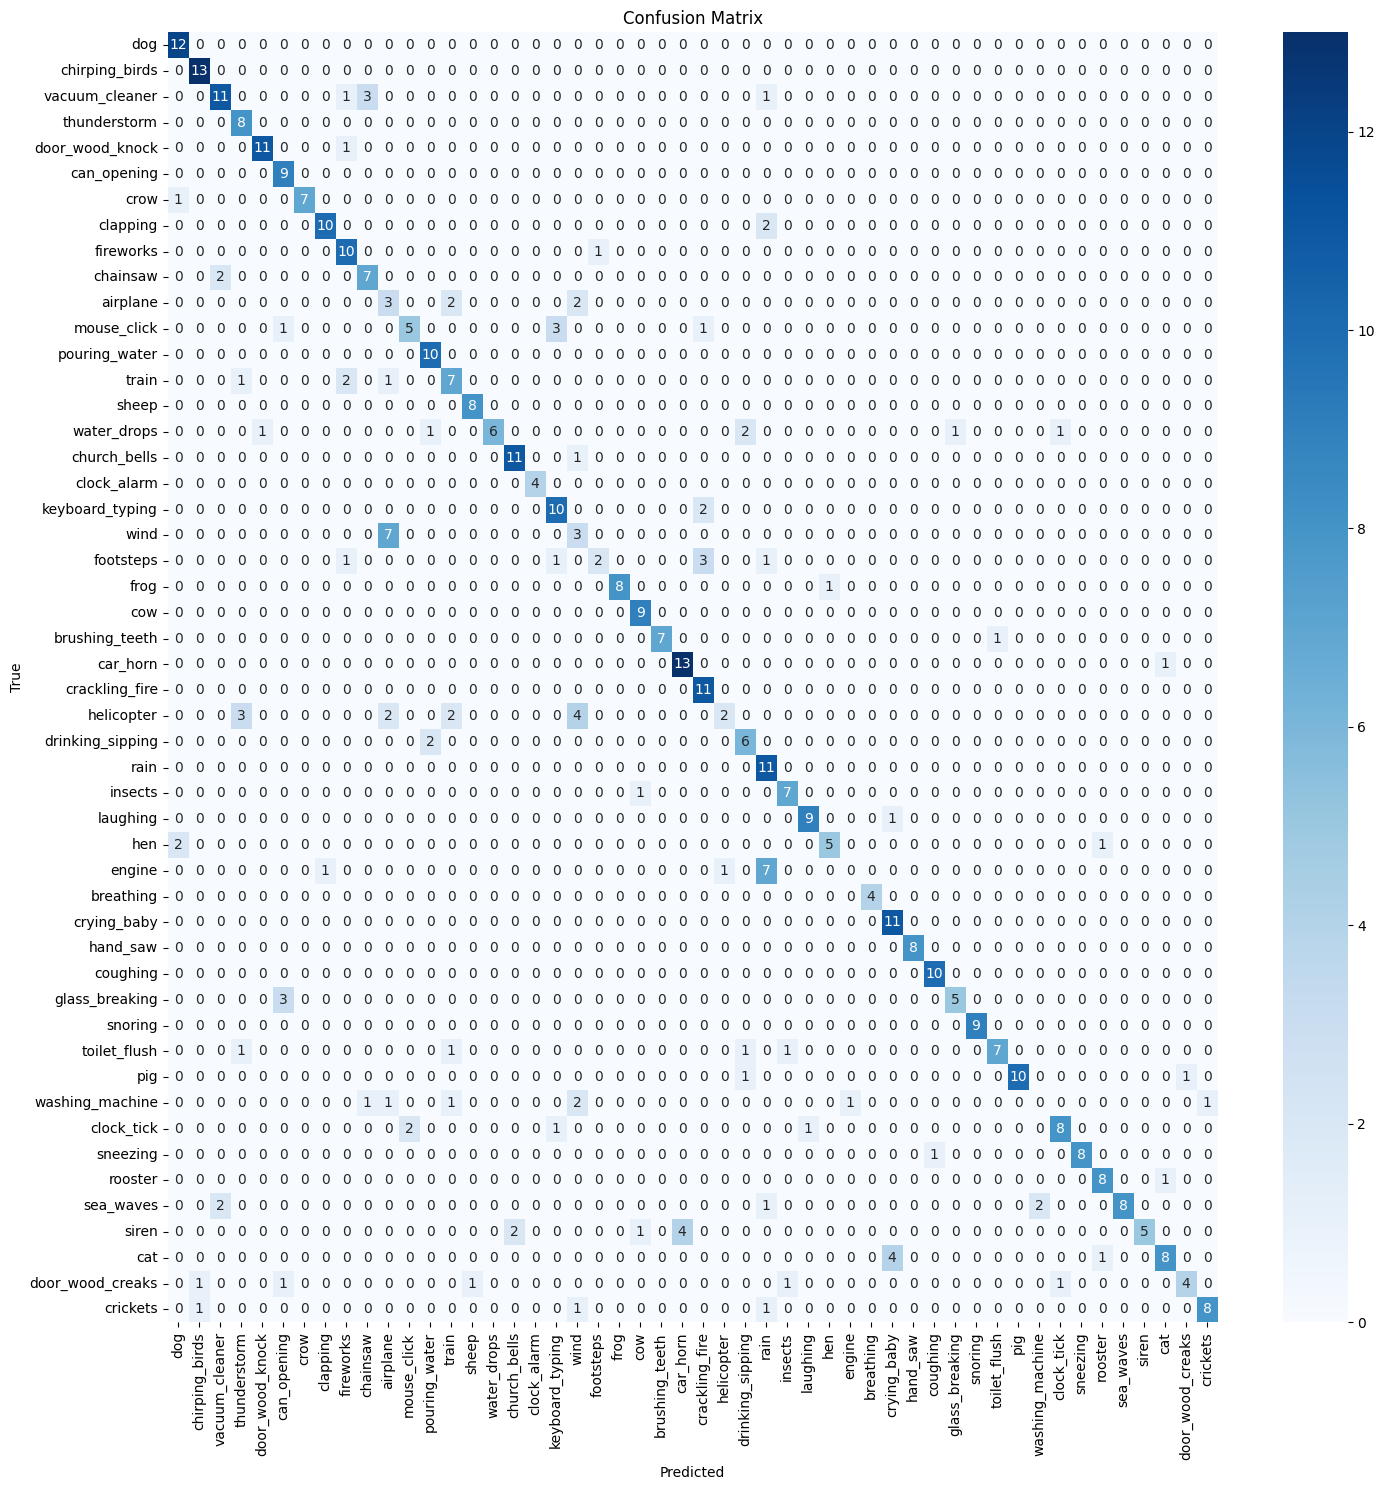

In [20]:
# Get predictions on the test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Create a confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(15, 15))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(labels, preds)

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Class': [id2label[i] for i in range(num_labels)],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Support': support
})

# Sort by F1 score
metrics_df = metrics_df.sort_values('F1 Score', ascending=False)
metrics_df

/home/nikhil-struck/miniconda3/envs/oreilly/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Class,Precision,Recall,F1 Score,Support
33,breathing,1.000000,1.000000,1.000000,4
22,cow,1.000000,1.000000,1.000000,9
1,chirping_birds,0.928571,1.000000,0.962963,13
24,car_horn,1.000000,0.928571,0.962963,14
4,door_wood_knock,1.000000,0.916667,0.956522,12
38,snoring,0.900000,1.000000,0.947368,9
44,rooster,0.900000,1.000000,0.947368,9
14,sheep,0.888889,1.000000,0.941176,8
21,frog,1.000000,0.888889,0.941176,9
6,crow,0.888889,1.000000,0.941176,8


## 7. Making Predictions with the Fine-tuned Model

Now that we have a fine-tuned model, let's use it to make predictions on new audio samples.

In [21]:
# Function to predict the class of an audio file
def predict_audio_class(audio, sampling_rate):
    # Load audio file
    audio = downsample_audio(audio, sampling_rate, 16000)

    # Extract features
    inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class
    predicted_class_id = torch.argmax(outputs.logits, dim=1).item()
    predicted_class = id2label[predicted_class_id]

    # Get confidence scores
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
    confidence = probabilities[predicted_class_id].item()

    return {
        'predicted_class': predicted_class,
        'confidence': confidence,
        'all_probabilities': {id2label[i]: prob.item() for i, prob in enumerate(probabilities)}
    }

In [22]:
# Let's test our model on a sample from the test set
sample = dataset['train'][1400]
sample_path = sample['audio']['path']
true_label = sample['category']

# Display the audio
print(f"True label: {true_label}")
IPythonAudio(data=sample['audio']['array'], rate=sample['audio']['sampling_rate'])

# Make prediction
prediction = predict_audio_class(sample['audio']['array'], sample['audio']['sampling_rate'])
print(f"Predicted class: {prediction['predicted_class']}")
print(f"Confidence: {prediction['confidence']:.4f}")

# Show top 5 predictions
top_predictions = sorted(
    prediction['all_probabilities'].items(),
    key=lambda x: x[1],
    reverse=True
)[:5]

print("\nTop 5 predictions:")
for class_name, prob in top_predictions:
    print(f"{class_name}: {prob:.4f}")

True label: snoring
Predicted class: snoring
Confidence: 0.4646

Top 5 predictions:
snoring: 0.4646
chainsaw: 0.2405
cow: 0.0370
door_wood_creaks: 0.0321
pig: 0.0181


## 8. Saving and Loading the Fine-tuned Model

Let's save our fine-tuned model so we can use it later without retraining.

In [23]:
# Save the model
output_dir = "./whisper-small-audio-classifier"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)

# Save label mappings
import json
with open(os.path.join(output_dir, "label_mappings.json"), "w") as f:
    json.dump({"id2label": id2label, "label2id": label2id}, f)

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50

In [24]:
# Function to load the model
def load_audio_classifier(model_path):
    # Load model and feature extractor
    model = WhisperForAudioClassification.from_pretrained(model_path)
    feature_extractor = WhisperFeatureExtractor.from_pretrained(model_path)

    # Load label mappings
    with open(os.path.join(model_path, "label_mappings.json"), "r") as f:
        mappings = json.load(f)
        id2label = {int(k): v for k, v in mappings["id2label"].items()}
        label2id = mappings["label2id"]

    return model, feature_extractor, id2label, label2id

## 9. Conclusion and Next Steps

In this notebook, we've demonstrated how to fine-tune the Whisper Small model for audio classification. We've covered:

1. Setting up the environment and installing required packages
2. Loading and preprocessing audio data
3. Preparing the Whisper model for fine-tuning
4. Training the model on our classification task
5. Evaluating the model's performance
6. Making predictions with the fine-tuned model
7. Saving and loading the model

### Possible Next Steps:

1. **Experiment with different hyperparameters**: Try different learning rates, batch sizes, or training epochs to improve performance.
2. **Data augmentation**: Apply techniques like adding noise, time shifting, or pitch shifting to increase the diversity of your training data.
3. **Try different model sizes**: Whisper comes in various sizes (tiny, base, small, medium, large). Experiment with different sizes to find the best trade-off between performance and computational requirements.
4. **Deploy the model**: Integrate your fine-tuned model into a web application or mobile app.
5. **Transfer to a different dataset**: Apply the same fine-tuning approach to a different audio classification dataset.

Remember that audio classification is just one of many tasks that Whisper can be fine-tuned for. The same approach can be adapted for speech recognition, speaker identification, emotion detection, and more.